In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

import _pickle as cPickle
import matplotlib as mpl

In [2]:
cat = np.genfromtxt('../forElena16Nov/SAGITTARIUS-II_cat16Nov.dat',names=True)

In [3]:
x = cat['x_f606w']
y = cat['y_f606w']
m606 = cat['magr_f606w']
dm606 = cat['err_f606w']
m814 = cat['magr_f814w']
dm814 = cat['err_f814w']

In [4]:
xgood = x
ygood = y

In [5]:
x0 = 2386.25
y0 = 2224.53

In [7]:
richness = 6071
x0 = 2527
y0 = 2235
gal_ext_pix = 2677

gal_ell = 0.14
gal_pa = -8

In [8]:
sag_x0 = x0
sag_y0 = y0

sag_nstar = 4000
sag_ext = 1.6/60 # degrees
sag_ext_pix = 3000
sag_ell = 0.2
sag_pa = 70

r_h = gal_ext_pix

In [9]:
def new_kernel_plummer(x,y,lon=sag_x0,lat=sag_y0,ext=sag_ext_pix,ell=sag_ell,pa=sag_pa):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [10]:
def model(theta_sag):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_sag[0]
    kwargs = dict(lon=theta_sag[1],lat=theta_sag[2],ext=theta_sag[3],ell=theta_sag[4],pa=theta_sag[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    # Default values for the other parameters
    #kwargs.update(ext=ERI_EXT_PIX,ell=ERI_ELL)

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel_plummer(xx,yy,**kwargs)
#     pdf = new_kernel(xx,yy,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = xdel*ydel
    model_counts = richness * pdf * pixarea
    return model_counts

In [11]:
xbin0 = np.ones((179,1))  # (fltarr(267)+1)
xbin1 = np.ones((1,179))  
xbin1[0] = np.arange(0,179,1)
xbin2 = xbin1 * 30 + 15  # (findgen(267)*30. + 15)
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

# creating x and y arrays to represent the bins across the image

In [12]:
def returnPDF(gal_pa_):
    costh = np.cos(-1 * np.deg2rad(gal_pa_))
    sinth = np.sin(-1 * np.deg2rad(gal_pa_))

    dx = xbin - x0
    dy = ybin - y0

    r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
    r2 = (dx * sinth + dy * costh)

    radius = np.sqrt(r1**2 + r2**2)
    
    r_h = gal_ext_pix
    norm = r_h**2 / (np.pi * (1-gal_ell))
    # half light radius squared / (pi * 1-ell)
    pdf = norm/((radius**2 + r_h**2)**2)

    return pdf, radius

In [13]:
pdf0, radius0 = returnPDF(0)
pdf30, radius30 = returnPDF(30)
pdf60, radius60 = returnPDF(60)
pdf90, radius90 = returnPDF(90)

In [14]:
xdel = 30.
ydel = 30.
pixarea = xdel*ydel  # pixel area in each bin

In [15]:
model_counts_gal0 = richness*pdf0*pixarea  # a 179x179 array
model_counts_gal30 = richness*pdf30*pixarea  # a 179x179 array
model_counts_gal60 = richness*pdf60*pixarea  # a 179x179 array
model_counts_gal90 = richness*pdf90*pixarea  # a 179x179 array

In [16]:
# Observed surface density map
binned_surface_density_30 = np.zeros((179,179))
for ii in range(179):
    for jj in range(179):
        idxgood = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idxgood)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [17]:
# Define annuli
radius1_0=radius0.flatten()
r1_0 = np.where(radius1_0 < (0.1 * r_h))[0]
r2_0 = np.where((radius1_0 < (0.2 * r_h)) & (radius1_0 >= (0.1 * r_h)))[0]
r3_0 = np.where((radius1_0 < (0.3 * r_h)) & (radius1_0 >= (0.2 * r_h)))[0]
r4_0 = np.where((radius1_0 < (0.4 * r_h)) & (radius1_0 >= (0.3 * r_h)))[0]
r5_0 = np.where((radius1_0 < (0.5 * r_h)) & (radius1_0 >= (0.4 * r_h)))[0]
r6_0 = np.where((radius1_0 < (0.6 * r_h)) & (radius1_0 >= (0.5 * r_h)))[0]
r7_0 = np.where((radius1_0 < (0.7 * r_h)) & (radius1_0 >= (0.6 * r_h)))[0]
r8_0 = np.where((radius1_0 < (0.8 * r_h)) & (radius1_0 >= (0.7 * r_h)))[0]
r9_0 = np.where((radius1_0 < (0.9 * r_h)) & (radius1_0 >= (0.8 * r_h)))[0]
r10_0 = np.where((radius1_0 < r_h) & (radius1_0 >= (0.9 * r_h)))[0]

In [18]:
# Define annuli
radius1_30=radius30.flatten()
r1_30 = np.where(radius1_30 < (0.1 * r_h))[0]
r2_30 = np.where((radius1_30 < (0.2 * r_h)) & (radius1_30 >= (0.1 * r_h)))[0]
r3_30 = np.where((radius1_30 < (0.3 * r_h)) & (radius1_30 >= (0.2 * r_h)))[0]
r4_30 = np.where((radius1_30 < (0.4 * r_h)) & (radius1_30 >= (0.3 * r_h)))[0]
r5_30 = np.where((radius1_30 < (0.5 * r_h)) & (radius1_30 >= (0.4 * r_h)))[0]
r6_30 = np.where((radius1_30 < (0.6 * r_h)) & (radius1_30 >= (0.5 * r_h)))[0]
r7_30 = np.where((radius1_30 < (0.7 * r_h)) & (radius1_30 >= (0.6 * r_h)))[0]
r8_30 = np.where((radius1_30 < (0.8 * r_h)) & (radius1_30 >= (0.7 * r_h)))[0]
r9_30 = np.where((radius1_30 < (0.9 * r_h)) & (radius1_30 >= (0.8 * r_h)))[0]
r10_30 = np.where((radius1_30 < r_h) & (radius1_30 >= (0.9 * r_h)))[0]

In [19]:
# Define annuli
radius1_60=radius60.flatten()
r1_60 = np.where(radius1_60 < (0.1 * r_h))[0]
r2_60 = np.where((radius1_60 < (0.2 * r_h)) & (radius1_60 >= (0.1 * r_h)))[0]
r3_60 = np.where((radius1_60 < (0.3 * r_h)) & (radius1_60 >= (0.2 * r_h)))[0]
r4_60 = np.where((radius1_60 < (0.4 * r_h)) & (radius1_60 >= (0.3 * r_h)))[0]
r5_60 = np.where((radius1_60 < (0.5 * r_h)) & (radius1_60 >= (0.4 * r_h)))[0]
r6_60 = np.where((radius1_60 < (0.6 * r_h)) & (radius1_60 >= (0.5 * r_h)))[0]
r7_60 = np.where((radius1_60 < (0.7 * r_h)) & (radius1_60 >= (0.6 * r_h)))[0]
r8_60 = np.where((radius1_60 < (0.8 * r_h)) & (radius1_60 >= (0.7 * r_h)))[0]
r9_60 = np.where((radius1_60 < (0.9 * r_h)) & (radius1_60 >= (0.8 * r_h)))[0]
r10_60 = np.where((radius1_60 < r_h) & (radius1_60 >= (0.9 * r_h)))[0]

In [20]:
# Define annuli
radius1_90=radius90.flatten()
r1_90 = np.where(radius1_90 < (0.1 * r_h))[0]
r2_90 = np.where((radius1_90 < (0.2 * r_h)) & (radius1_90 >= (0.1 * r_h)))[0]
r3_90 = np.where((radius1_90 < (0.3 * r_h)) & (radius1_90 >= (0.2 * r_h)))[0]
r4_90 = np.where((radius1_90 < (0.4 * r_h)) & (radius1_90 >= (0.3 * r_h)))[0]
r5_90 = np.where((radius1_90 < (0.5 * r_h)) & (radius1_90 >= (0.4 * r_h)))[0]
r6_90 = np.where((radius1_90 < (0.6 * r_h)) & (radius1_90 >= (0.5 * r_h)))[0]
r7_90 = np.where((radius1_90 < (0.7 * r_h)) & (radius1_90 >= (0.6 * r_h)))[0]
r8_90 = np.where((radius1_90 < (0.8 * r_h)) & (radius1_90 >= (0.7 * r_h)))[0]
r9_90 = np.where((radius1_90 < (0.9 * r_h)) & (radius1_90 >= (0.8 * r_h)))[0]
r10_90 = np.where((radius1_90 < r_h) & (radius1_90 >= (0.9 * r_h)))[0]

In [21]:
arr = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
r_annuli = (arr + 0.05) * r_h

# .05r_h, .15r_h
area_annuli = np.pi * ( (r_annuli + (0.05*r_h))**2 - (r_annuli - (0.05*r_h))**2) * (1-gal_ell)

In [22]:
pix_per_arcsec=20
area_arcmin = area_annuli/(pix_per_arcsec*60)**2

In [23]:
aa = area_arcmin
dist_x = np.array([r_h*0.1,r_h*0.2,r_h*0.3,r_h*0.4,r_h*0.5,r_h*0.6,r_h*0.7,r_h*0.8,r_h*0.9,r_h])/1200

In [24]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_galf0 = model_counts_gal0.flatten()
model_counts_galf30 = model_counts_gal30.flatten()
model_counts_galf60 = model_counts_gal60.flatten()
model_counts_galf90 = model_counts_gal90.flatten()
# model_counts_expf = model_counts_exp.flatten()
data_1d0 = [binned_surface_density_30f[r1_0].sum()/aa[0],
           binned_surface_density_30f[r2_0].sum()/aa[1],
           binned_surface_density_30f[r3_0].sum()/aa[2],
           binned_surface_density_30f[r4_0].sum()/aa[3],
           binned_surface_density_30f[r5_0].sum()/aa[4],
           binned_surface_density_30f[r6_0].sum()/aa[5],
           binned_surface_density_30f[r7_0].sum()/aa[6],
           binned_surface_density_30f[r8_0].sum()/aa[7],
           binned_surface_density_30f[r9_0].sum()/aa[8],
           binned_surface_density_30f[r10_0].sum()/aa[9]]

data_1d30 = [binned_surface_density_30f[r1_30].sum()/aa[0],
           binned_surface_density_30f[r2_30].sum()/aa[1],
           binned_surface_density_30f[r3_30].sum()/aa[2],
           binned_surface_density_30f[r4_30].sum()/aa[3],
           binned_surface_density_30f[r5_30].sum()/aa[4],
           binned_surface_density_30f[r6_30].sum()/aa[5],
           binned_surface_density_30f[r7_30].sum()/aa[6],
           binned_surface_density_30f[r8_30].sum()/aa[7],
           binned_surface_density_30f[r9_30].sum()/aa[8],
           binned_surface_density_30f[r10_30].sum()/aa[9]]

data_1d60 = [binned_surface_density_30f[r1_60].sum()/aa[0],
           binned_surface_density_30f[r2_60].sum()/aa[1],
           binned_surface_density_30f[r3_60].sum()/aa[2],
           binned_surface_density_30f[r4_60].sum()/aa[3],
           binned_surface_density_30f[r5_60].sum()/aa[4],
           binned_surface_density_30f[r6_60].sum()/aa[5],
           binned_surface_density_30f[r7_60].sum()/aa[6],
           binned_surface_density_30f[r8_60].sum()/aa[7],
           binned_surface_density_30f[r9_60].sum()/aa[8],
           binned_surface_density_30f[r10_60].sum()/aa[9]]

data_1d90 = [binned_surface_density_30f[r1_90].sum()/aa[0],
           binned_surface_density_30f[r2_90].sum()/aa[1],
           binned_surface_density_30f[r3_90].sum()/aa[2],
           binned_surface_density_30f[r4_90].sum()/aa[3],
           binned_surface_density_30f[r5_90].sum()/aa[4],
           binned_surface_density_30f[r6_90].sum()/aa[5],
           binned_surface_density_30f[r7_90].sum()/aa[6],
           binned_surface_density_30f[r8_90].sum()/aa[7],
           binned_surface_density_30f[r9_90].sum()/aa[8],
           binned_surface_density_30f[r10_90].sum()/aa[9]]

model_1d0 = [model_counts_galf0[r1_0].sum()/aa[0],
            model_counts_galf0[r2_0].sum()/aa[1],
            model_counts_galf0[r3_0].sum()/aa[2],
            model_counts_galf0[r4_0].sum()/aa[3],
            model_counts_galf0[r5_0].sum()/aa[4],
            model_counts_galf0[r6_0].sum()/aa[5],
            model_counts_galf0[r7_0].sum()/aa[6],
            model_counts_galf0[r8_0].sum()/aa[7],
            model_counts_galf0[r9_0].sum()/aa[8],
            model_counts_galf0[r10_0].sum()/aa[9]]

In [25]:
model_1d30 = [model_counts_galf30[r1_30].sum()/aa[0],
            model_counts_galf30[r2_30].sum()/aa[1],
            model_counts_galf30[r3_30].sum()/aa[2],
            model_counts_galf30[r4_30].sum()/aa[3],
            model_counts_galf30[r5_30].sum()/aa[4],
            model_counts_galf30[r6_30].sum()/aa[5],
            model_counts_galf30[r7_30].sum()/aa[6],
            model_counts_galf30[r8_30].sum()/aa[7],
            model_counts_galf30[r9_30].sum()/aa[8],
            model_counts_galf30[r10_30].sum()/aa[9]]

model_1d60 = [model_counts_galf60[r1_60].sum()/aa[0],
            model_counts_galf60[r2_60].sum()/aa[1],
            model_counts_galf60[r3_60].sum()/aa[2],
            model_counts_galf60[r4_60].sum()/aa[3],
            model_counts_galf60[r5_60].sum()/aa[4],
            model_counts_galf60[r6_60].sum()/aa[5],
            model_counts_galf60[r7_60].sum()/aa[6],
            model_counts_galf60[r8_60].sum()/aa[7],
            model_counts_galf60[r9_60].sum()/aa[8],
            model_counts_galf60[r10_60].sum()/aa[9]]

model_1d90 = [model_counts_galf90[r1_90].sum()/aa[0],
            model_counts_galf90[r2_90].sum()/aa[1],
            model_counts_galf90[r3_90].sum()/aa[2],
            model_counts_galf90[r4_90].sum()/aa[3],
            model_counts_galf90[r5_90].sum()/aa[4],
            model_counts_galf90[r6_90].sum()/aa[5],
            model_counts_galf90[r7_90].sum()/aa[6],
            model_counts_galf90[r8_90].sum()/aa[7],
            model_counts_galf90[r9_90].sum()/aa[8],
            model_counts_galf90[r10_90].sum()/aa[9]]

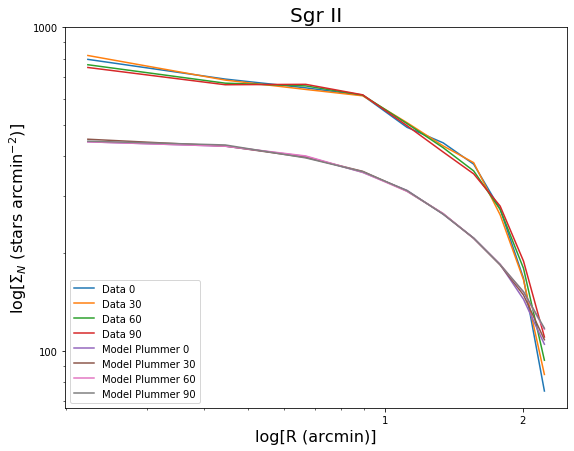

In [26]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(dist_x,data_1d0,label='Data 0')
ax.plot(dist_x,data_1d30,label='Data 30')
ax.plot(dist_x,data_1d60,label='Data 60')
ax.plot(dist_x,data_1d90,label='Data 90')
ax.plot(dist_x,model_1d0,label='Model Plummer 0')
ax.plot(dist_x,model_1d30,label='Model Plummer 30')
ax.plot(dist_x,model_1d60,label='Model Plummer 60')
ax.plot(dist_x,model_1d90,label='Model Plummer 90')

# ax.plot(dist_x,model_1de,label='Model Exp')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-2}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Sgr II',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yticks([1e+2, 1e+3])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend()
plt.savefig('figures/sgr2_1802pa.png')
plt.show()